In [33]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from collections import Counter
import io

from sklearn.model_selection import train_test_split
from music21 import *
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
from keras.layers import *
from keras.models import *
from keras.callbacks import *
import keras.backend as K

In [2]:
#https://www.analyticsvidhya.com/blog/2020/01/how-to-perform-automatic-music-generation/
def read_midi(file):
    
    print("Loading Music File:",file)
    
    notes=[]
    notes_to_parse = None
    
    #parsing a midi file
    midi = converter.parse(file)
  
    #grouping based on different instruments
    s2 = instrument.partitionByInstrument(midi)

    #Looping over instruments
    for part in s2.parts:
    
        #select elements of only piano
        if 'Piano' in str(part): 
        
            notes_to_parse = part.recurse() 
      
            #if note or a chord
            for element in notes_to_parse:
                
                if isinstance(element, note.Note):
                    notes.append(str(element.pitch))
                
                elif isinstance(element, chord.Chord):
                    notes.append('.'.join(str(n) for n in element.normalOrder))

    return np.array(notes)

In [3]:
path='/content/'

#read all the filenames
files=[i for i in os.listdir(path) if i.endswith(".mid")]

#reading each midi file
notes_array = np.array([read_midi(path+i) for i in files])

Loading Music File: /content/beethoven_opus22_3.mid
Loading Music File: /content/mond_1.mid
Loading Music File: /content/alb_se2.mid
Loading Music File: /content/beethoven_opus22_2.mid
Loading Music File: /content/bach_846.mid
Loading Music File: /content/alb_se4.mid
Loading Music File: /content/beethoven_opus10_1.mid
Loading Music File: /content/beethoven_hammerklavier_4.mid
Loading Music File: /content/beethoven_les_adieux_3.mid
Loading Music File: /content/alb_se3.mid
Loading Music File: /content/pathetique_2.mid
Loading Music File: /content/bach_847.mid
Loading Music File: /content/beethoven_opus90_1.mid
Loading Music File: /content/alb_esp4.mid
Loading Music File: /content/alb_se8.mid
Loading Music File: /content/appass_3.mid
Loading Music File: /content/waldstein_1.mid
Loading Music File: /content/alb_esp1.mid
Loading Music File: /content/beethoven_opus22_1.mid
Loading Music File: /content/beethoven_opus90_2.mid
Loading Music File: /content/alb_se6.mid
Loading Music File: /conten

This first model contains 47 classical music songs.

In [37]:
print(len(notes_))

92697


In [39]:
print("First fifty notes:",notes_[:50])

First fifty notes: ['D4', 'E-4', 'F4', 'B-2', 'B-3', 'D4', 'B-3', 'A4', 'G4', 'E-4', 'F4', 'G4', 'C4', 'A4', 'B-4', 'D4', 'C#4', 'F4', 'D4', 'B-3', 'A4', 'G4', 'E-4', 'F4', 'G4', 'C4', 'A4', 'B-4', 'D4', 'C#4', 'A4', 'B-4', 'D4', 'A3', 'C5', 'D5', 'B-3', 'G3', 'E5', '4.10', 'F3', '5.9', 'F4', 'F5', 'E-5', 'D5', 'E-5', 'F5', 'G5', 'F3']


Total note of 92,697 for the 47 files used in this particular iteration of the model.

In [4]:
#flatten array
notes_ = [element for note_ in notes_array for element in note_]

#No. of unique notes
unique_notes = list(set(notes_))
print(len(unique_notes))

308


308 unique notes found in this midi set.

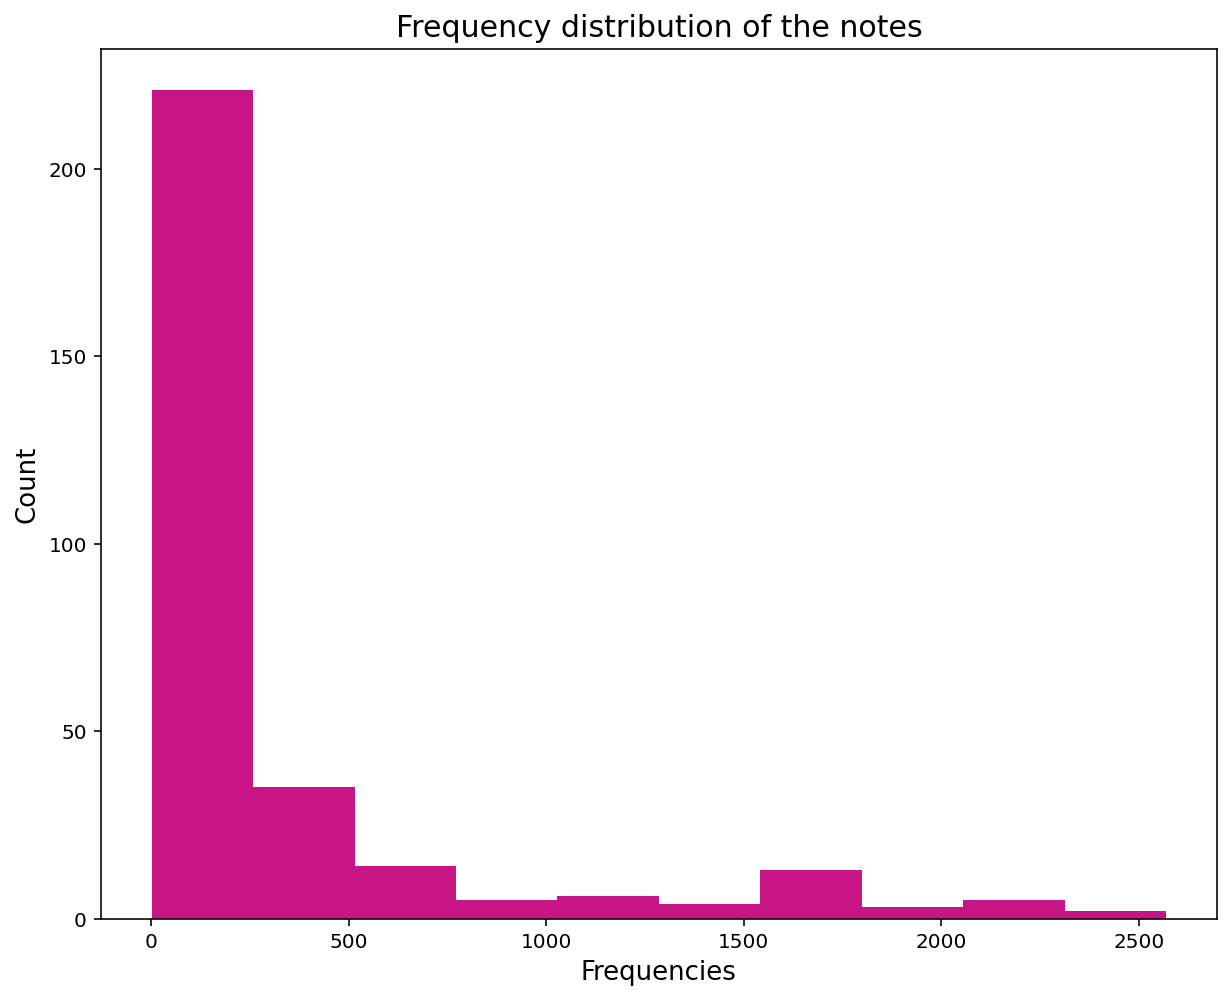

In [41]:
#computing frequency of each note
freq = dict(Counter(notes_))

#consider only the frequencies
only_freq=[count for _,count in freq.items()]

plt.figure(figsize=(10,8))

plt.title("Frequency distribution of the notes", fontsize=15)
plt.ylabel('Count', fontsize= 13)
plt.xlabel('Frequencies', fontsize= 13)
plt.hist(only_freq, color = 'mediumvioletred')
plt.savefig('1stdistplot.png');

Appears that most common frequencies are lower than 250 as their count exceeds the 200 mark while everything else appears 50 times or less. 

In [6]:
frequent_notes = [note_ for note_, count in freq.items() if count>=50]
print(len(frequent_notes))

158


158 notes make more than 50 appearances.

In [7]:
#files will only contain frequent notes
new_music=[]

for notes in notes_array:
    temp=[]
    for note_ in notes:
        if note_ in frequent_notes:
            temp.append(note_)            
    new_music.append(temp)
    
new_music = np.array(new_music)

In [8]:
#preparing input and output sequences where input is sequence of amplitude values and the output is the subsequent value
no_of_timesteps = 32
x = []
y = []

for note_ in new_music:
    for i in range(0, len(note_) - no_of_timesteps, 1):
        
        #preparing input and output sequences
        input_ = note_[i:i + no_of_timesteps]
        output = note_[i + no_of_timesteps]
        
        x.append(input_)
        y.append(output)
        
x=np.array(x)
y=np.array(y)

In [9]:
#Each note gets a unique integer
unique_x = list(set(x.ravel()))
x_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_x))

In [10]:
#preparing input sequences
x_seq=[]
for i in x:
    temp=[]
    for j in i:
        #assigning unique integer to every note
        temp.append(x_note_to_int[j])
    x_seq.append(temp)
    
x_seq = np.array(x_seq)

In [11]:
#preparing integer sequences for output data.
unique_y = list(set(y))
y_note_to_int = dict((note_, number) for number, note_ in enumerate(unique_y)) 
y_seq=np.array([y_note_to_int[i] for i in y])

In [12]:
x_tr, x_val, y_tr, y_val = train_test_split(x_seq,y_seq,test_size=0.2,random_state=0)

### Wavenet model

In [15]:

model = Sequential()

model.add(Embedding(len(unique_x), 100, input_length=32, trainable=True))
#conv1d learns local patterns of dta in cnns
model.add(Conv1D(64,3, padding = 'causal', activation = 'relu'))
model.add(Dropout(0.2))
# reduce dimensionality of this vector and overfitting, 
# we dont want to just repeat notes
model.add(MaxPool1D(2))

model.add(Conv1D(128,3, activation= 'relu', dilation_rate=2, padding='causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(Conv1D(256,3, activation = 'relu', dilation_rate=4, padding= 'causal'))
model.add(Dropout(0.2))
model.add(MaxPool1D(2))

model.add(GlobalMaxPool1D())

model.add(Dense(256, activation='relu'))
model.add(Dense(len(unique_y), activation = 'softmax'))

model.compile(loss = 'sparse_categorical_crossentropy', optimizer='adam')

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 32, 100)           15800     
                                                                 
 conv1d (Conv1D)             (None, 32, 64)            19264     
                                                                 
 dropout (Dropout)           (None, 32, 64)            0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 16, 64)           0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 16, 128)           24704     
                                                                 
 dropout_1 (Dropout)         (None, 16, 128)           0         
                                                        

In [16]:
mc=ModelCheckpoint('best_model.h5', monitor = 'val_loss', mode = 'min',
                   save_best_only=True, verbose =1)
#min is the objective of chosen metric in order to decrease it.

In [17]:
history = model.fit(np.array(x_tr), np.array(y_tr), batch_size=128, 
                    epochs=50, validation_data=(np.array(x_val),
                                                np.array(y_val)),verbose =1, callbacks=[mc])

Epoch 1/50
560/560 [==============================] - ETA: 0s - loss: 4.1654
Epoch 00001: val_loss improved from inf to 3.97059, saving model to best_model.h5
560/560 [==============================] - 13s 7ms/step - loss: 4.1654 - val_loss: 3.9706
Epoch 2/50
558/560 [============================>.] - ETA: 0s - loss: 3.7306
Epoch 00002: val_loss improved from 3.97059 to 3.76555, saving model to best_model.h5
560/560 [==============================] - 4s 7ms/step - loss: 3.7304 - val_loss: 3.7655
Epoch 3/50
558/560 [============================>.] - ETA: 0s - loss: 3.5845
Epoch 00003: val_loss improved from 3.76555 to 3.68948, saving model to best_model.h5
560/560 [==============================] - 4s 7ms/step - loss: 3.5846 - val_loss: 3.6895
Epoch 4/50
558/560 [============================>.] - ETA: 0s - loss: 3.4894
Epoch 00004: val_loss improved from 3.68948 to 3.55543, saving model to best_model.h5
560/560 [==============================] - 4s 7ms/step - loss: 3.4893 - val_loss: 3.

In [18]:
from keras.models import load_model
model =load_model('best_model.h5')

### Generate music

In [20]:
import random
ind =np.random.randint(0,len(x_val)-1)

random_music = x_val[ind]

predictions = []

for i in range(10):
  random_music = random_music.reshape(1,no_of_timesteps)

  prob = model.predict(random_music)[0]

  y_pred = np.argmax(prob, axis=0)
  predictions.append(y_pred)

  random_music=np.insert(random_music[0], len(random_music[0]),y_pred)
  random_music = random_music[1:]

print(predictions)

[4, 4, 12, 79, 4, 4, 79, 4, 4, 4]


In [21]:
#integers to notes
x_int_to_note = dict((number, note_) for number, note_ in enumerate(unique_x))

predicted_notes = [x_int_to_note[i] for i in predictions]

In [24]:
# convert preds to midi files
def convert_to_midi(prediction_output):

  offset = 0
  output_notes = []

  for pattern in prediction_output:

    if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                
                cn=int(current_note)
                new_note = note.Note(cn)
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
                
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
            
        # pattern is a note
    else:    
      new_note = note.Note(pattern)
      new_note.offset = offset
      new_note.storedInstrument = instrument.Piano()
      output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
    offset += 1
  midi_stream = stream.Stream(output_notes)
  midi_stream.write('midi', fp='music.mid')

In [25]:
convert_to_midi(predicted_notes)

In [26]:
predicted_notes

['C#5', 'C#5', 'B4', 'E-5', 'C#5', 'C#5', 'E-5', 'C#5', 'C#5', 'C#5']

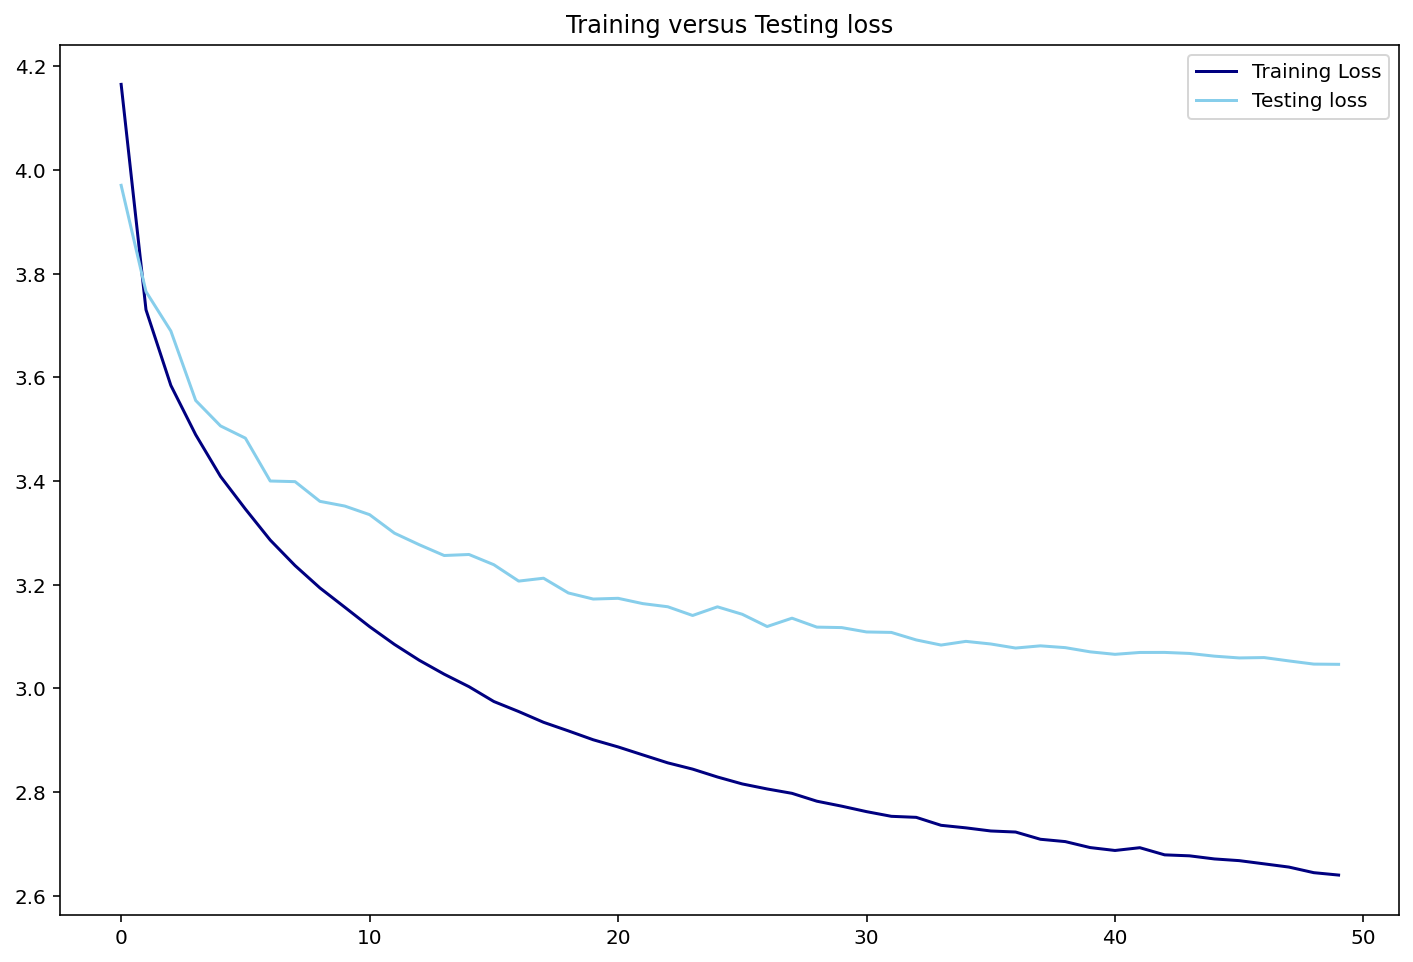

In [30]:
train_loss=history.history['loss']
test_loss= history.history['val_loss']


plt.figure(figsize=(12,8))
plt.title('Training versus Testing loss')
plt.plot(train_loss, label ='Training Loss', color = 'navy')
plt.plot(test_loss, label = 'Testing loss', color = 'skyblue')
plt.legend();
plt.savefig('1stmodel_loss_plot.png')

This is an instance where you do want to be underfit, since you dont want to create a replica of an original work, but you want the model to have just enough variance to create a new work.  However, fitting it more data should lead to a increased performance in the model. 

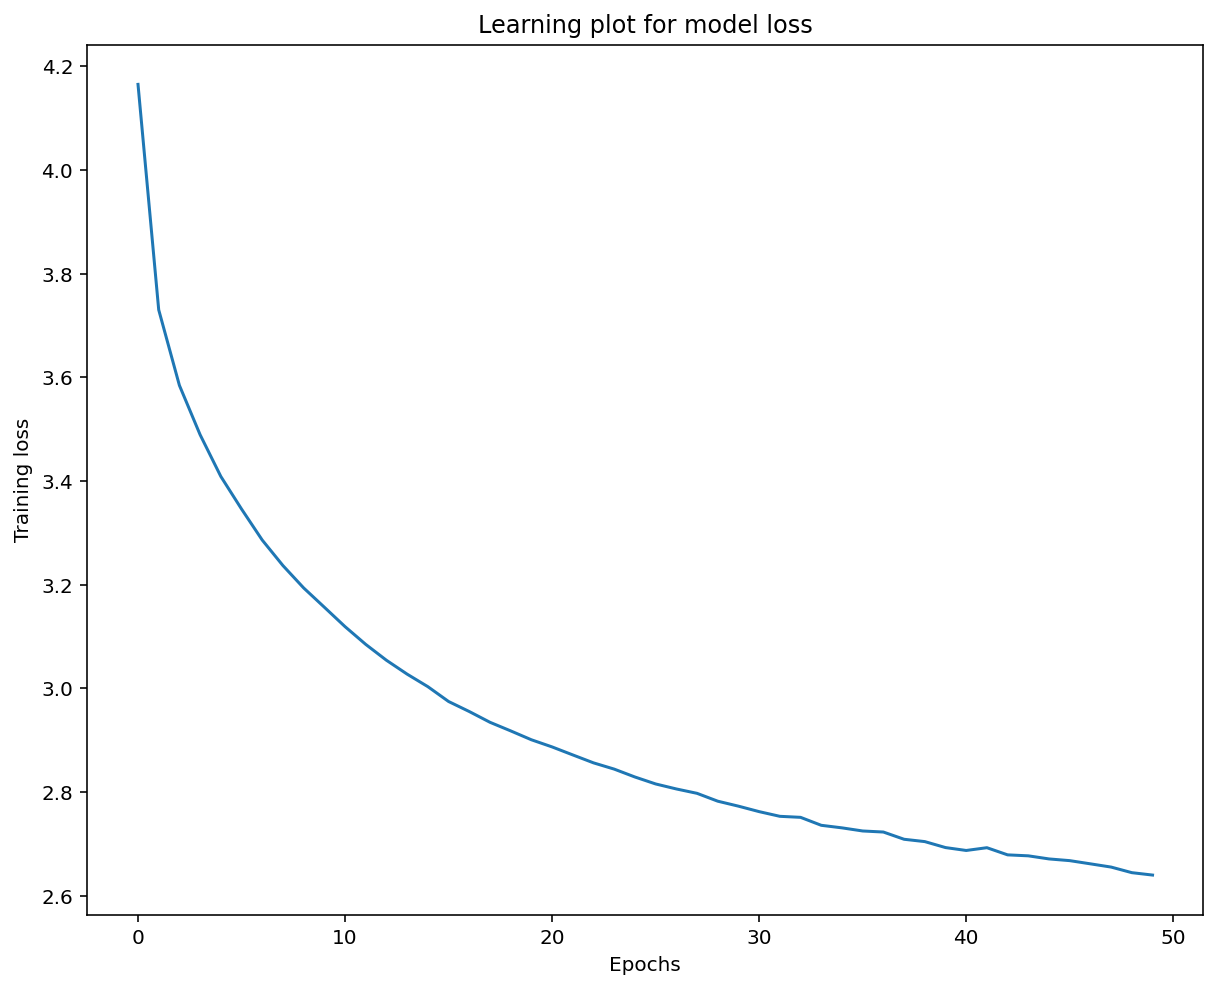

In [36]:
history_df = pd.DataFrame(history.history)

plt.figure(figsize=(10,8))
plt.title('Learning plot for model loss')
plt.plot(history_df['loss'])
plt.xlabel('Epochs')
plt.ylabel('Training loss');
plt.savefig('1st_learning_plot.png')